# Module 1: Operations on Qubits – Physics, Mathematics, and Control

## 🚀 Introduction: The Imperative of Error Mitigation

In the NISQ (Noisy Intermediate-Scale Quantum) era, quantum computers are powerful but fundamentally flawed. When you run a circuit, the result, $x_{noisy}$, is distorted by physical errors.

While the long-term solution is Quantum Error Correction (QEC), the overhead is too great for current hardware. Instead, we use **Quantum Error Mitigation (QEM)**, which is algorithmic post-processing and data-driven techniques to estimate the ideal expectation value ($\hat{x}_i$) from noisy measurement data ($x_n$).

**The Challenge:** Build a post-processing function $f_\theta$ (an AI model) that predicts the ideal result $x_{ideal}$ from noisy data: 
$$x_{ideal} \approx f_\theta(x_{noisy}, \text{Circuit Features})$$

To succeed, your AI model must understand the underlying quantum mechanical processes that generate the noise data.

In [ ]:
import sys

# 1. Uninstall the conflicting 1.0+ versions
print("Downgrading to stable versions...")
!pip uninstall -y qiskit qiskit-ibm-runtime qiskit-dynamics qiskit-aer

# 2. Install the "Golden Combination" that is guaranteed to work together
# qiskit==0.46.0 contains the required 'pulse' module
# qiskit-dynamics==0.4.3 is built specifically for this version
!pip install "qiskit==0.46.0" "qiskit-ibm-runtime==0.20.0" "qiskit-dynamics==0.4.3" "qiskit-aer==0.13.3" "numpy" "matplotlib" "scikit-learn" "torch"

print("------------------------------------------------")
print("✅ Downgrade Complete. The 'pulse' module has been restored.")
print("⚠️ CRITICAL: Go to 'Kernel' -> 'Restart Kernel' now for changes to take effect.")

## 1.1 The Physical Realization: Superconducting Transmons

To effectively mitigate errors, one must first understand the physical origin of quantum operations. A qubit is not a digital bit; it is an analog microwave resonator. The primary platform for the competition's data is the **superconducting transmon qubit**.

### From Harmonic to Anharmonic Oscillators
A standard LC circuit behaves as a Quantum Harmonic Oscillator with equally spaced energy levels.
$$\hat{H}_{LC} = \hbar \omega_r \left( \hat{a}^\dagger \hat{a} + \frac{1}{2} \right)$$

This equal spacing is a problem: a control pulse intended to drive the $|0\rangle \to |1\rangle$ transition would *also* drive the $|1\rangle \to |2\rangle$ transition, preventing us from isolating the computational subspace $\{|0\rangle, |1\rangle\}$.

The solution is the **Josephson Junction (JJ)**, which acts as a non-linear inductor, introducing an **anharmonicity ($\alpha$)**.

The transmon Hamiltonian is approximately:
$$\hat{H} \approx 4E_C (\hat{n} - n_g)^2 - E_J \cos(\hat{\phi})$$

This non-linearity makes the energy levels unequal, allowing us to uniquely address the $|0\rangle \to |1\rangle$ transition ($\omega_{01}$) without exciting the $|1\rangle \to |2\rangle$ transition ($\omega_{12}$), provided $\omega_{12} \approx \omega_{01} + \alpha$ where $\alpha$ is typically $-300$ to $-350$ MHz.

### Leakage Errors
Despite the anharmonicity, errors occur. If a control pulse is too short in time, its spectral width in frequency becomes broad (due to the Fourier limit). If this spectral width overlaps with $\omega_{12}$, the qubit can transition to the non-computational $|2\rangle$ state. This is known as **leakage**.

**Insight for AI:** Leakage is a non-Clifford, non-unital error that violates the two-level assumption of many standard QEM techniques like Zero-Noise Extrapolation (ZNE). If the dataset includes higher-energy occupation probabilities, a leakage-aware model may be required.

## 1.2 The Mathematical Ideal: The Bloch Sphere

Mathematically, a single qubit state is a vector in a two-dimensional complex Hilbert space $\mathbb{C}^2$:
$$|\psi\rangle = \alpha |0\rangle + \beta |1\rangle \quad \text{where } |\alpha|^2 + |\beta|^2 = 1$$

This state can be visualized as a point on the surface of the **Bloch Sphere**.

### Single Qubit Gates as Rotations
Operations are unitary transformations that correspond to rotations on the Bloch sphere:

* **Pauli-X ($X$):** $180^\circ$ rotation around the X-axis. Swaps $|0\rangle \leftrightarrow |1\rangle$.
    $$X = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}$$
* **Pauli-Z ($Z$):** $180^\circ$ rotation around the Z-axis. Adds a relative phase $\pi$.
    $$Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}$$
* **Hadamard ($H$):** Creates superposition. Maps $|0\rangle \to \frac{|0\rangle+|1\rangle}{\sqrt{2}}$.
    $$H = \frac{1}{\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}$$

### The Crucial Insight: Virtual Z-Gates
The physical implementation of gates is never perfect, leading to coherent errors (e.g., over-rotation). However, **Z-gates** are an exception:

* **Physical X/Y Gates** are implemented by sending a microwave pulse.
* **Virtual Z Gates** are implemented in **software** by changing the phase of the *next* microwave pulse.

**This means Z gates are perfect (zero error)**. This is a crucial feature for your AI model to leverage: you can treat the $Z$ operations in your circuit as noise-free.

## 1.3 Pulse-Level Implementation and Control

A quantum gate is not an instantaneous matrix multiplication; it is a precisely timed physical drive, often lasting nanoseconds.

### Rabi Oscillations
To implement an $X$-gate ($180^\circ$ rotation), a microwave drive field is applied. Think of this as pushing a child on a swing at the resonant frequency. Continuous pushing causes the state to oscillate between $|0\rangle$ and $|1\rangle$ (Rabi oscillation).

The gate is completed by stopping the pulse at the exact time $t_{gate}$ needed to achieve the target state. The rotation angle $\theta$ is determined by the integral of the Rabi frequency $\Omega(t)$ over the pulse duration:

$$\int_0^{t_{gate}} \Omega(t) dt = \theta$$

If the integral is slightly off (e.g., $1.01\pi$ instead of $\pi$), the gate results in an **over-rotation error**, which is a type of **coherent error**.

### Implementation: Simulating Physics with Qiskit Dynamics
We use `Qiskit Dynamics` to simulate the Schrödinger equation and visualize how a microwave pulse drives a qubit.

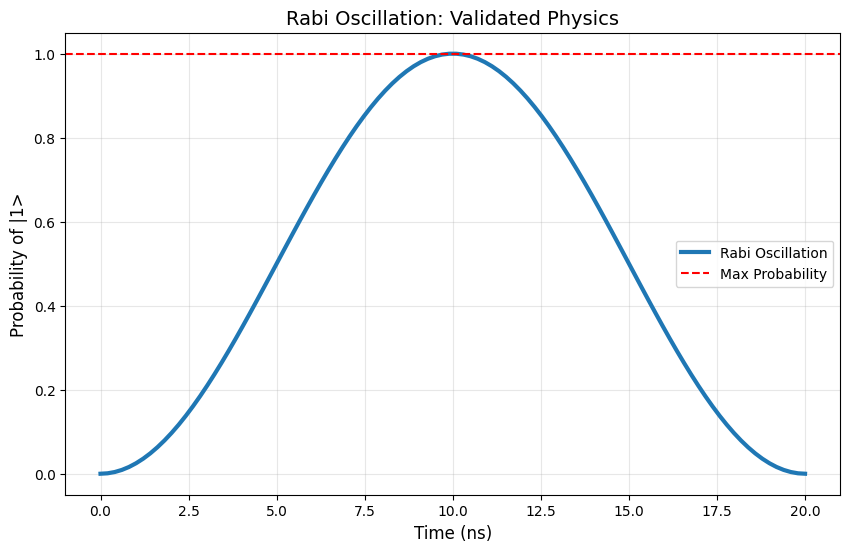

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_dynamics import Solver
from qiskit_dynamics.signals import Signal

# --- ROBUST PHYSICS SETUP ---

# 1. We simulate directly in the "Rotating Frame"
# In this frame, the qubit effectively has 0 energy (static),
# and the drive is a constant push (DC) rather than a 5GHz wave.
# This makes the math fail-safe.

# 2. Define Operators
# Pauli X: The operator that flips the qubit
X_op = np.array([[0, 1], [1, 0]], dtype=complex)
# Static Hamiltonian: 0 (since we are in the frame)
static_ham = np.zeros((2, 2), dtype=complex)

# 3. Configure Solver
# We tell the solver: "Here is a qubit with 0 energy. We will push it with X_op."
solver = Solver(
    static_hamiltonian=static_ham,
    hamiltonian_operators=[X_op]
)

# 4. Define the Pulse
# We want a "Pi Pulse" (180 degree rotation)
# Duration = 20 ns
# To rotate by Pi in 20ns, we need specific amplitude:
# Amplitude * Duration = Pi  ->  Amplitude = Pi / 20ns
duration = 20e-9
target_angle = np.pi
amp = target_angle / duration

# Create a constant square pulse (no carrier frequency needed in this frame)
# This represents the "envelope" of the microwave.
pulse_signal = Signal(envelope=amp, carrier_freq=0.0)

# 5. Solve
t_span = np.linspace(0, duration, 100)
sol = solver.solve(
    t_span=[0, duration],
    y0=np.array([1., 0.]), # Start in Ground State |0>
    signals=[pulse_signal],
    t_eval=t_span
)

# 6. Visualize
# Probability of state |1> (Excited state)
probs = [np.abs(y[1])**2 for y in sol.y]

plt.figure(figsize=(10, 6))
plt.plot(t_span*1e9, probs, linewidth=3, label="Rabi Oscillation")
plt.axhline(1.0, color='r', linestyle='--', label="Max Probability")
plt.xlabel("Time (ns)", fontsize=12)
plt.ylabel("Probability of |1>", fontsize=12)
plt.title("Rabi Oscillation: Validated Physics", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()